In [48]:
# EDA - Análise de Despesas dos Deputados
# Análise Exploratória de Dados usando os modelos do Snowflake

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("📊 Iniciando EDA - Análise de Despesas dos Deputados")
print("=" * 60)

📊 Iniciando EDA - Análise de Despesas dos Deputados


In [49]:
# Conexão com Snowflake
import snowflake.connector
from dotenv import load_dotenv
import os

load_dotenv()

# Configuração da conexão Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='CAMARA',
    schema='DEV'
)

def execute_query(query):
    """Executa query no Snowflake e retorna DataFrame"""
    cursor = conn.cursor()
    cursor.execute(query)
    columns = [desc[0] for desc in cursor.description]
    data = cursor.fetchall()
    cursor.close()
    return pd.DataFrame(data, columns=columns)

print("✅ Conexão com Snowflake estabelecida")

✅ Conexão com Snowflake estabelecida


# 📋 Carregamento dos Dados

Vamos carregar os dados dos modelos dbt já criados para realizar nossa análise exploratória.

In [50]:
# Carregando dados das views/tabelas do dbt
print("📥 Carregando dados das views do dbt...")

# 1. Ranking de deputados por ano
query_ranking_deputados = """
SELECT * FROM VW_RANKING_DEPUTADOS
WHERE ano >= 2019
ORDER BY ano DESC, total_gasto DESC
"""
df_ranking_deputados = execute_query(query_ranking_deputados)

# 2. Ranking de partidos
query_ranking_partidos = """
SELECT * FROM VW_RANKING_PARTIDOS  
WHERE ano >= 2019
ORDER BY ano DESC, total_gasto_partido DESC
"""
df_ranking_partidos = execute_query(query_ranking_partidos)

# 3. Despesas detalhadas por deputado
query_despesas_deputado = """
SELECT * FROM VW_DESPESAS_DEPUTADO
WHERE ano >= 2019
ORDER BY ano DESC, total_valor_liquido DESC
"""
df_despesas_deputado = execute_query(query_despesas_deputado)

# 4. Dados da tabela fato com joins para análises detalhadas
query_fato_despesas = """
SELECT 
    f.cod_documento,
    f.data_documento,
    f.valor_documento,
    f.valor_liquido,
    f.valor_glosa,
    dd.nome_deputado,
    dd.sigla_partido,
    dd.sigla_uf,
    dd.id_legislatura,
    dt.ano,
    dt.mes,
    dt.nome_mes,
    dt.trimestre,
    df.nome_fornecedor,
    dtd.tipo_despesa
FROM FCT_DESPESAS f
INNER JOIN DIM_DEPUTADOS dd ON f.sk_deputado = dd.sk_deputado
INNER JOIN DIM_TEMPO dt ON f.sk_tempo = dt.sk_tempo
LEFT JOIN DIM_FORNECEDORES df ON f.sk_fornecedor = df.sk_fornecedor
LEFT JOIN DIM_TIPO_DESPESA dtd ON f.sk_tipo_despesa = dtd.sk_tipo_despesa
WHERE dt.ano >= 2019
"""
df_fato_despesas = execute_query(query_fato_despesas)

print(f"✅ Dados carregados:")
print(f"   - Ranking Deputados: {len(df_ranking_deputados):,} registros")
print(f"   - Ranking Partidos: {len(df_ranking_partidos):,} registros") 
print(f"   - Despesas por Deputado: {len(df_despesas_deputado):,} registros")
print(f"   - Fato Despesas: {len(df_fato_despesas):,} registros")

📥 Carregando dados das views do dbt...
✅ Dados carregados:
   - Ranking Deputados: 4,112 registros
   - Ranking Partidos: 601 registros
   - Despesas por Deputado: 35,071 registros
   - Fato Despesas: 3,045,121 registros


# 🔍 Visão Geral dos Dados

Vamos começar explorando a estrutura e qualidade dos nossos dados.

In [51]:
# Visão geral dos dados
print("📊 RESUMO EXECUTIVO DOS DADOS")
print("=" * 50)

# Período analisado
anos_analisados = sorted(df_fato_despesas['ANO'].unique())
print(f"📅 Período analisado: {min(anos_analisados)} - {max(anos_analisados)}")

# Totais gerais
total_gasto = df_fato_despesas['VALOR_LIQUIDO'].sum()
total_documentos = len(df_fato_despesas)
deputados_unicos = df_fato_despesas['NOME_DEPUTADO'].nunique()
partidos_unicos = df_fato_despesas['SIGLA_PARTIDO'].nunique()
fornecedores_unicos = df_fato_despesas['NOME_FORNECEDOR'].nunique()

print(f"💰 Total gasto: R$ {total_gasto:,.2f}")
print(f"📄 Total de documentos: {total_documentos:,}")
print(f"👥 Deputados únicos: {deputados_unicos:,}")
print(f"🏛️ Partidos únicos: {partidos_unicos:,}")
print(f"🏢 Fornecedores únicos: {fornecedores_unicos:,}")
# Estatísticas por ano
print("\n📈 GASTOS POR ANO:")
gastos_por_ano = df_fato_despesas.groupby('ANO')['VALOR_LIQUIDO'].agg(['sum', 'count', 'mean']).round(2)
gastos_por_ano.columns = ['Total (R$)', 'Qtd Docs', 'Média (R$)']

# Formatação para evitar notação científica
pd.options.display.float_format = '{:,.2f}'.format
print(gastos_por_ano)

📊 RESUMO EXECUTIVO DOS DADOS
📅 Período analisado: 2019 - 2025
💰 Total gasto: R$ 2,087,896,389.18
📄 Total de documentos: 3,045,121
👥 Deputados únicos: 894
🏛️ Partidos únicos: 36
🏢 Fornecedores únicos: 46,823

📈 GASTOS POR ANO:
         Total (R$)  Qtd Docs  Média (R$)
ANO                                      
2019 311,591,878.73    760605      409.66
2020 249,437,818.09    399630      624.17
2021 366,210,282.77    534787      684.78
2022 403,765,343.27    469528      859.94
2023 224,843,043.17    270350      831.67
2024 286,402,354.40    338104      847.08
2025 245,645,668.75    272117      902.72


# 🎯 H1: Análise Governo vs Oposição

**Hipótese**: Deputados da base do governo gastam mais quando são base que quando são oposição.

Vamos analisar os gastos dos partidos entre as legislaturas 2019-2023 e 2023-2027.

In [52]:
# H1: Análise Governo vs Oposição
print("🎯 HIPÓTESE 1: GOVERNO vs OPOSIÇÃO")
print("=" * 50)

# Definindo partidos base/oposição por período
# 2019-2022 (Bolsonaro): PL, Republicanos, PP foram mais alinhados
# 2023+ (Lula): PT, PSB, PDT, PCdoB mais alinhados

partidos_base_bolsonaro = ['PL', 'REPUBLICANOS', 'PP', 'PSL', 'NOVO']
partidos_base_lula = ['PT', 'PSB', 'PDT', 'PCdoB', 'PV', 'PSOL', 'REDE']

# Função para classificar governo/oposição
def classificar_governo_oposicao(row):
    if row['ANO'] <= 2022:
        if row['SIGLA_PARTIDO'] in partidos_base_bolsonaro:
            return 'Base Governo (Bolsonaro)'
        else:
            return 'Oposição (Bolsonaro)'
    else:
        if row['SIGLA_PARTIDO'] in partidos_base_lula:
            return 'Base Governo (Lula)'
        else:
            return 'Oposição (Lula)'

# Aplicar classificação
df_fato_despesas['CLASSIFICACAO_GOVERNO'] = df_fato_despesas.apply(classificar_governo_oposicao, axis=1)

# Análise por período governamental
analise_governo = df_fato_despesas.groupby(['ANO', 'CLASSIFICACAO_GOVERNO']).agg({
    'VALOR_LIQUIDO': ['sum', 'mean', 'count'],
    'NOME_DEPUTADO': 'nunique'
}).round(2)

analise_governo.columns = ['Total_Gasto', 'Gasto_Medio', 'Qtd_Docs', 'Qtd_Deputados']
analise_governo = analise_governo.reset_index()

print("📊 Gastos por Classificação Governo/Oposição:")
print(analise_governo)

# Gasto médio per capita por classificação
analise_governo['Gasto_Per_Capita'] = analise_governo['Total_Gasto'] / analise_governo['Qtd_Deputados']
print("\n💰 Gasto médio per capita por deputado:")
print(analise_governo[['ANO', 'CLASSIFICACAO_GOVERNO', 'Gasto_Per_Capita']].pivot(
    index='ANO', columns='CLASSIFICACAO_GOVERNO', values='Gasto_Per_Capita'
))

🎯 HIPÓTESE 1: GOVERNO vs OPOSIÇÃO
📊 Gastos por Classificação Governo/Oposição:
     ANO     CLASSIFICACAO_GOVERNO    Total_Gasto  Gasto_Medio  Qtd_Docs  \
0   2019  Base Governo (Bolsonaro)  84,414,393.44       390.58    216127   
1   2019      Oposição (Bolsonaro) 227,177,485.29       417.24    544478   
2   2020  Base Governo (Bolsonaro)  86,630,721.98       592.86    146123   
3   2020      Oposição (Bolsonaro) 162,807,096.11       642.22    253507   
4   2021  Base Governo (Bolsonaro) 128,845,441.01       717.49    179578   
5   2021      Oposição (Bolsonaro) 237,364,841.76       668.24    355209   
6   2022  Base Governo (Bolsonaro) 138,332,829.07       956.30    144654   
7   2022      Oposição (Bolsonaro) 265,432,514.20       817.03    324874   
8   2023       Base Governo (Lula)  56,959,080.15       651.33     87450   
9   2023           Oposição (Lula) 167,883,963.02       917.90    182900   
10  2024       Base Governo (Lula)  72,710,658.49       660.81    110032   
11  2024 

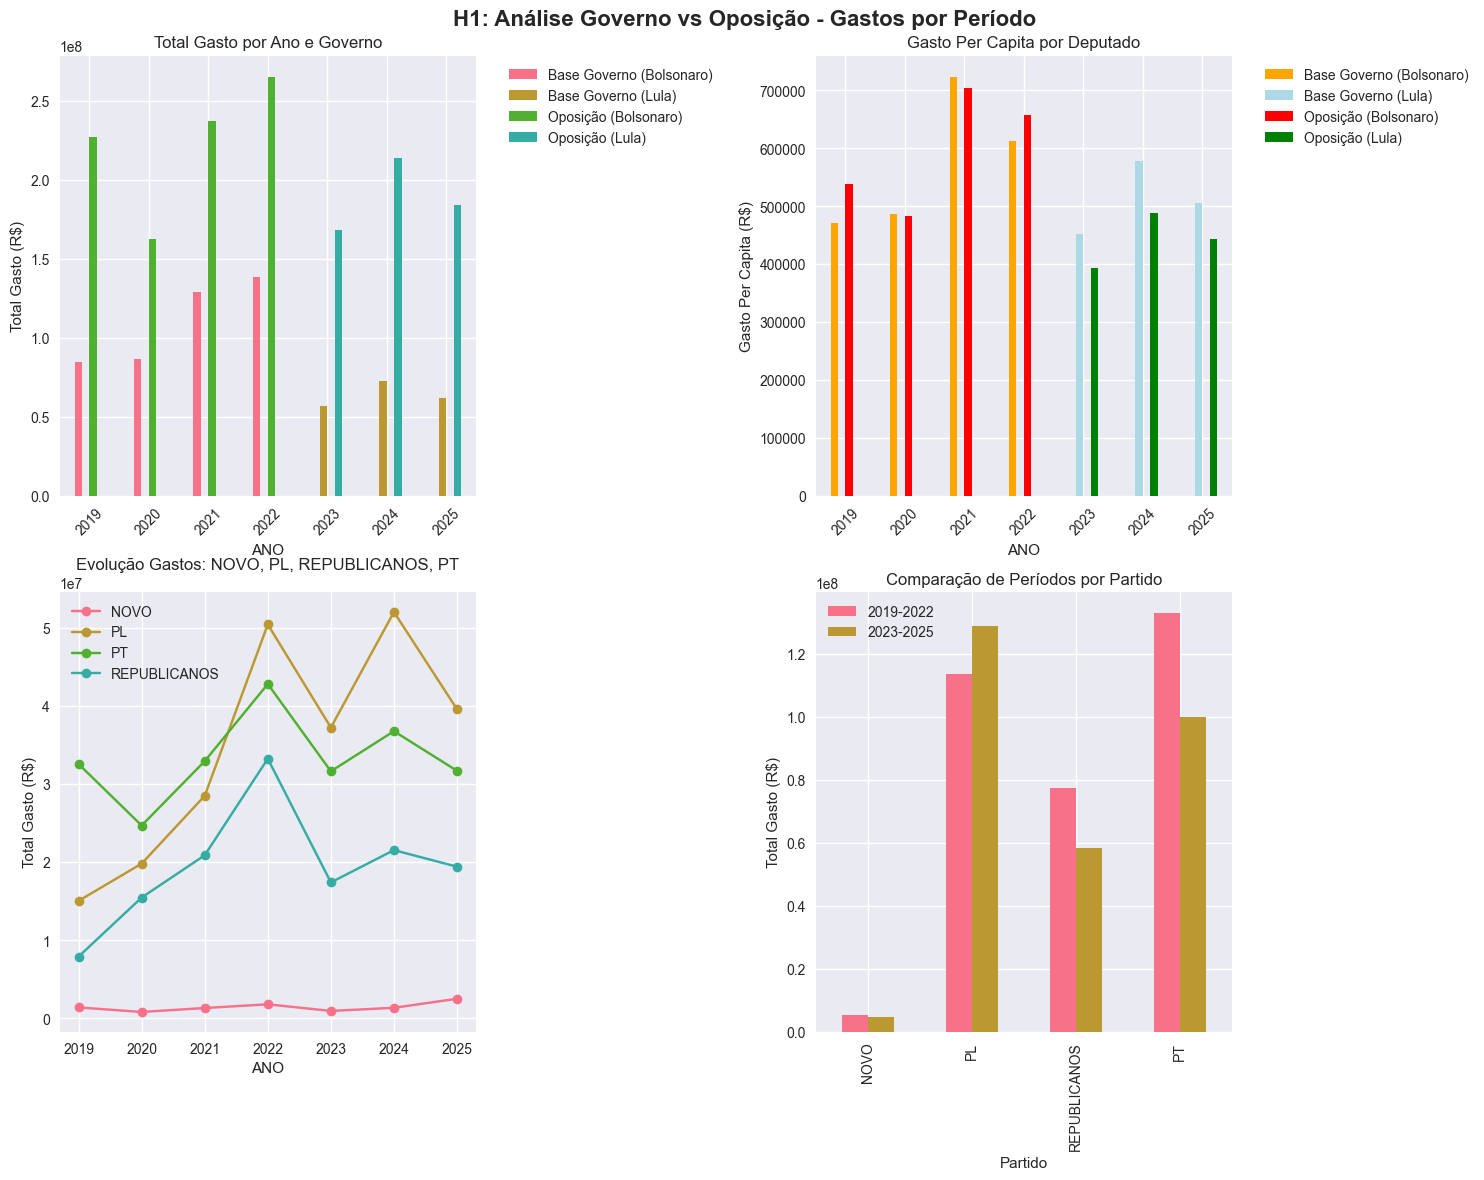


📈 Variação percentual entre períodos:
        Partido  Variacao%
0          NOVO      -9.63
1            PL      13.25
2  REPUBLICANOS     -24.69
3            PT     -24.74


In [53]:
# Visualização H1: Governo vs Oposição
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('H1: Análise Governo vs Oposição - Gastos por Período', fontsize=16, fontweight='bold')

# 1. Total gasto por ano e classificação
pivot_total = analise_governo.pivot(index='ANO', columns='CLASSIFICACAO_GOVERNO', values='Total_Gasto')
pivot_total.plot(kind='bar', ax=axes[0,0], rot=45)
axes[0,0].set_title('Total Gasto por Ano e Governo')
axes[0,0].set_ylabel('Total Gasto (R$)')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Gasto per capita
pivot_per_capita = analise_governo.pivot(index='ANO', columns='CLASSIFICACAO_GOVERNO', values='Gasto_Per_Capita')
pivot_per_capita.plot(kind='bar', ax=axes[0,1], rot=45, color=['orange', 'lightblue', 'red', 'green'])
axes[0,1].set_title('Gasto Per Capita por Deputado')
axes[0,1].set_ylabel('Gasto Per Capita (R$)')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Evolução temporal - apenas partidos específicos mencionados
partidos_analise = ['NOVO', 'PL', 'REPUBLICANOS', 'PT']
df_partidos_especificos = df_fato_despesas[df_fato_despesas['SIGLA_PARTIDO'].isin(partidos_analise)]

gastos_partidos_tempo = df_partidos_especificos.groupby(['ANO', 'SIGLA_PARTIDO'])['VALOR_LIQUIDO'].sum().unstack()
gastos_partidos_tempo.plot(ax=axes[1,0], marker='o')
axes[1,0].set_title('Evolução Gastos: NOVO, PL, REPUBLICANOS, PT')
axes[1,0].set_ylabel('Total Gasto (R$)')
axes[1,0].legend()

# 4. Comparação específica 2019-2022 vs 2023+
periodo_1 = df_fato_despesas[df_fato_despesas['ANO'].isin([2019, 2020, 2021, 2022])]
periodo_2 = df_fato_despesas[df_fato_despesas['ANO'].isin([2023, 2024, 2025])]

comparacao_periodos = []
for partido in partidos_analise:
    gasto_p1 = periodo_1[periodo_1['SIGLA_PARTIDO'] == partido]['VALOR_LIQUIDO'].sum()
    gasto_p2 = periodo_2[periodo_2['SIGLA_PARTIDO'] == partido]['VALOR_LIQUIDO'].sum()
    comparacao_periodos.append({
        'Partido': partido,
        '2019-2022': gasto_p1,
        '2023-2025': gasto_p2,
        'Variacao%': ((gasto_p2 - gasto_p1) / gasto_p1 * 100) if gasto_p1 > 0 else 0
    })

df_comparacao = pd.DataFrame(comparacao_periodos)
df_comparacao.set_index('Partido')[['2019-2022', '2023-2025']].plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Comparação de Períodos por Partido')
axes[1,1].set_ylabel('Total Gasto (R$)')

plt.tight_layout()
plt.show()

print("\n📈 Variação percentual entre períodos:")
print(df_comparacao[['Partido', 'Variacao%']])

# 🤝 H2: Relação com Fornecedores

**Hipótese**: Alguns fornecedores concentram grande parte das notas para deputados de um mesmo partido ou UF.

In [54]:
# H2: Análise de concentração de fornecedores
print("🤝 HIPÓTESE 2: RELAÇÃO COM FORNECEDORES")
print("=" * 50)

# Remover registros sem fornecedor
df_com_fornecedor = df_fato_despesas[df_fato_despesas['NOME_FORNECEDOR'].notna()].copy()

# Top fornecedores geral
print("🏢 TOP 10 FORNECEDORES (Valor Total):")
top_fornecedores = df_com_fornecedor.groupby('NOME_FORNECEDOR').agg({
    'VALOR_LIQUIDO': 'sum',
    'SIGLA_PARTIDO': 'nunique',
    'SIGLA_UF': 'nunique',
    'NOME_DEPUTADO': 'nunique',
    'COD_DOCUMENTO': 'count'
}).round(2)

top_fornecedores.columns = ['Total_Valor', 'Qtd_Partidos', 'Qtd_UFs', 'Qtd_Deputados', 'Qtd_Notas']
top_fornecedores = top_fornecedores.sort_values('Total_Valor', ascending=False).head(10)
print(top_fornecedores)

# Concentração por partido
print("\n🎯 ANÁLISE DE CONCENTRAÇÃO POR PARTIDO:")
concentracao_partido = []

for fornecedor in top_fornecedores.index[:5]:  # Top 5 fornecedores
    df_fornecedor = df_com_fornecedor[df_com_fornecedor['NOME_FORNECEDOR'] == fornecedor]
    gastos_por_partido = df_fornecedor.groupby('SIGLA_PARTIDO')['VALOR_LIQUIDO'].sum().sort_values(ascending=False)
    
    total_fornecedor = gastos_por_partido.sum()
    partido_principal = gastos_por_partido.index[0]
    concentracao = (gastos_por_partido.iloc[0] / total_fornecedor) * 100
    
    concentracao_partido.append({
        'Fornecedor': fornecedor[:50] + '...' if len(fornecedor) > 50 else fornecedor,
        'Partido_Principal': partido_principal,
        'Concentracao_%': concentracao,
        'Total_Valor': total_fornecedor
    })

df_concentracao_partido = pd.DataFrame(concentracao_partido)
print(df_concentracao_partido)

# Concentração por UF
print("\n📍 ANÁLISE DE CONCENTRAÇÃO POR UF:")
concentracao_uf = []

for fornecedor in top_fornecedores.index[:5]:
    df_fornecedor = df_com_fornecedor[df_com_fornecedor['NOME_FORNECEDOR'] == fornecedor]
    gastos_por_uf = df_fornecedor.groupby('SIGLA_UF')['VALOR_LIQUIDO'].sum().sort_values(ascending=False)
    
    total_fornecedor = gastos_por_uf.sum()
    uf_principal = gastos_por_uf.index[0]
    concentracao = (gastos_por_uf.iloc[0] / total_fornecedor) * 100
    
    concentracao_uf.append({
        'Fornecedor': fornecedor[:50] + '...' if len(fornecedor) > 50 else fornecedor,
        'UF_Principal': uf_principal,
        'Concentracao_%': concentracao,
        'Total_Valor': total_fornecedor
    })

df_concentracao_uf = pd.DataFrame(concentracao_uf)
print(df_concentracao_uf)

🤝 HIPÓTESE 2: RELAÇÃO COM FORNECEDORES
🏢 TOP 10 FORNECEDORES (Valor Total):
                                          Total_Valor  Qtd_Partidos  Qtd_UFs  \
NOME_FORNECEDOR                                                                
TAM                                    491,105,263.95            30       27   
LOCALIZA RENT A CAR SA                 108,381,504.50            24       24   
AZUL                                    83,065,313.34            27       27   
LOCALIZA RENT A CAR S/A                 79,045,292.97            21       16   
CASCOL COMBUSTIVEIS PARA VEICULOS LTDA  71,492,188.92            35       27   
CIA AÉREA - TAM                         39,913,182.69            34       27   
CIA AÉREA - GOL                         39,526,325.47            35       27   
TELEFONICA BRASIL S.A.                  17,132,104.78            30       27   
MOVIDA LOCACAO DE VEICULOS S.A.         16,342,366.60            25       23   
HPE AUTOMOTORES DO BRASIL LTDA          15,3

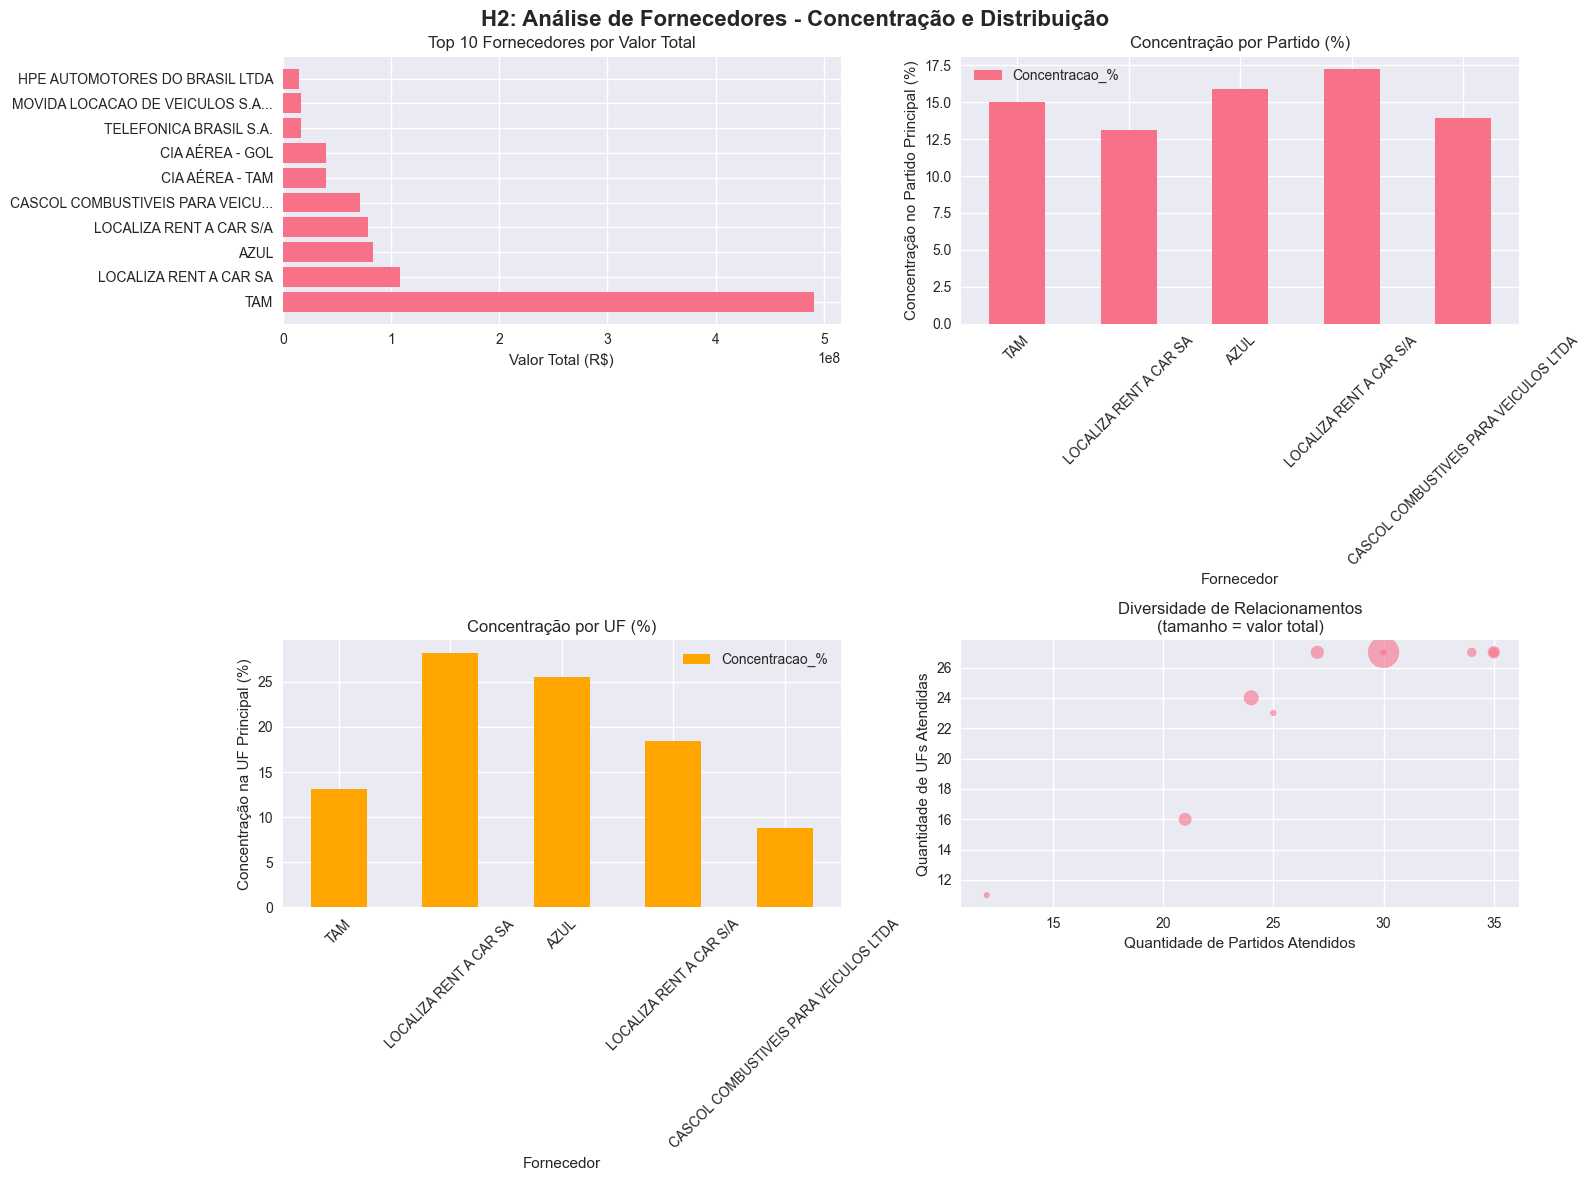


📊 ÍNDICE DE CONCENTRAÇÃO (0-100, onde 100 = monopolizado):
                               Fornecedor  Indice_Concentracao
0                                     TAM                 7.97
1                  LOCALIZA RENT A CAR SA                 7.27
2                                    AZUL                 7.81
3                 LOCALIZA RENT A CAR S/A                11.35
4  CASCOL COMBUSTIVEIS PARA VEICULOS LTDA                 7.15


In [55]:
# Visualização H2: Fornecedores
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('H2: Análise de Fornecedores - Concentração e Distribuição', fontsize=16, fontweight='bold')

# 1. Top 10 fornecedores por valor
top_10_fornecedores = top_fornecedores.head(10)
fornecedores_nomes = [nome[:30] + '...' if len(nome) > 30 else nome for nome in top_10_fornecedores.index]

axes[0,0].barh(fornecedores_nomes, top_10_fornecedores['Total_Valor'])
axes[0,0].set_title('Top 10 Fornecedores por Valor Total')
axes[0,0].set_xlabel('Valor Total (R$)')

# 2. Distribuição de partidos por fornecedor (top 5)
df_concentracao_partido.plot(x='Fornecedor', y='Concentracao_%', kind='bar', ax=axes[0,1], rot=45)
axes[0,1].set_title('Concentração por Partido (%)')
axes[0,1].set_ylabel('Concentração no Partido Principal (%)')

# 3. Distribuição de UFs por fornecedor (top 5)
df_concentracao_uf.plot(x='Fornecedor', y='Concentracao_%', kind='bar', ax=axes[1,0], rot=45, color='orange')
axes[1,0].set_title('Concentração por UF (%)')
axes[1,0].set_ylabel('Concentração na UF Principal (%)')

# 4. Diversidade de relacionamentos (partidos vs UFs)
axes[1,1].scatter(top_10_fornecedores['Qtd_Partidos'], top_10_fornecedores['Qtd_UFs'], 
                 s=top_10_fornecedores['Total_Valor']/1000000, alpha=0.6)
axes[1,1].set_xlabel('Quantidade de Partidos Atendidos')
axes[1,1].set_ylabel('Quantidade de UFs Atendidas')
axes[1,1].set_title('Diversidade de Relacionamentos\n(tamanho = valor total)')

plt.tight_layout()
plt.show()

# Índice de concentração (Herfindahl-Hirschman Index simplificado)
print("\n📊 ÍNDICE DE CONCENTRAÇÃO (0-100, onde 100 = monopolizado):")
indices_concentracao = []
for fornecedor in top_fornecedores.index[:5]:
    df_fornecedor = df_com_fornecedor[df_com_fornecedor['NOME_FORNECEDOR'] == fornecedor]
    gastos_por_partido = df_fornecedor.groupby('SIGLA_PARTIDO')['VALOR_LIQUIDO'].sum()
    shares = gastos_por_partido / gastos_por_partido.sum()
    hhi = (shares ** 2).sum() * 100
    
    indices_concentracao.append({
        'Fornecedor': fornecedor[:40] + '...' if len(fornecedor) > 40 else fornecedor,
        'Indice_Concentracao': round(hhi, 2)
    })

df_indices = pd.DataFrame(indices_concentracao)
print(df_indices)

# ⏰ H3: Temporalidade e Mandato

**Hipótese**: Gastos sobem nos meses que antecedem as eleições, especialmente em divulgação e locomoção.

In [56]:
# H3: Análise temporal e sazonalidade
print("⏰ HIPÓTESE 3: TEMPORALIDADE E MANDATO")
print("=" * 50)

# Anos eleitorais: 2018 (federais), 2020 (municipais), 2022 (federais), 2024 (municipais)
anos_eleitorais = [2018, 2020, 2022, 2024]
anos_nao_eleitorais = [2019, 2021, 2023, 2025]

# Análise mensal
gastos_mensais = df_fato_despesas.groupby(['ANO', 'MES']).agg({
    'VALOR_LIQUIDO': 'sum',
    'COD_DOCUMENTO': 'count'
}).reset_index()

# Classificar anos eleitorais
gastos_mensais['TIPO_ANO'] = gastos_mensais['ANO'].apply(
    lambda x: 'Eleitoral' if x in anos_eleitorais else 'Não Eleitoral'
)

# Média por mês em anos eleitorais vs não eleitorais
media_mensal = gastos_mensais.groupby(['MES', 'TIPO_ANO'])['VALOR_LIQUIDO'].mean().unstack()

print("📅 MÉDIA DE GASTOS POR MÊS (Anos Eleitorais vs Não Eleitorais):")
print(media_mensal.round(2))

# Análise de sazonalidade
print("\n📈 VARIAÇÃO PERCENTUAL - ANOS ELEITORAIS vs NÃO ELEITORAIS:")
if 'Não Eleitoral' in media_mensal.columns and 'Eleitoral' in media_mensal.columns:
    variacao = ((media_mensal['Eleitoral'] - media_mensal['Não Eleitoral']) / 
                media_mensal['Não Eleitoral'] * 100).round(2)
    print(variacao)

# Análise por tipo de despesa em anos eleitorais
print("\n🗳️ ANÁLISE POR TIPO DE DESPESA EM ANOS ELEITORAIS:")
df_anos_eleitorais = df_fato_despesas[df_fato_despesas['ANO'].isin(anos_eleitorais)]
gastos_tipo_eleitoral = df_anos_eleitorais.groupby('TIPO_DESPESA')['VALOR_LIQUIDO'].sum().sort_values(ascending=False)
print(gastos_tipo_eleitoral.head(10))

# Comparação com anos não eleitorais
df_anos_nao_eleitorais = df_fato_despesas[df_fato_despesas['ANO'].isin(anos_nao_eleitorais)]
gastos_tipo_nao_eleitoral = df_anos_nao_eleitorais.groupby('TIPO_DESPESA')['VALOR_LIQUIDO'].sum().sort_values(ascending=False)

# Tipos de despesa que mais crescem em anos eleitorais
tipos_comuns = set(gastos_tipo_eleitoral.index) & set(gastos_tipo_nao_eleitoral.index)
crescimento_eleitoral = []

for tipo in tipos_comuns:
    if gastos_tipo_nao_eleitoral[tipo] > 0:
        crescimento = ((gastos_tipo_eleitoral[tipo] - gastos_tipo_nao_eleitoral[tipo]) / 
                      gastos_tipo_nao_eleitoral[tipo] * 100)
        crescimento_eleitoral.append({
            'Tipo_Despesa': tipo,
            'Eleitoral': gastos_tipo_eleitoral[tipo],
            'Nao_Eleitoral': gastos_tipo_nao_eleitoral[tipo],
            'Crescimento_%': crescimento
        })

df_crescimento = pd.DataFrame(crescimento_eleitoral).sort_values('Crescimento_%', ascending=False)
print("\n📊 TIPOS DE DESPESA COM MAIOR CRESCIMENTO EM ANOS ELEITORAIS:")
print(df_crescimento.head(10))

⏰ HIPÓTESE 3: TEMPORALIDADE E MANDATO
📅 MÉDIA DE GASTOS POR MÊS (Anos Eleitorais vs Não Eleitorais):
TIPO_ANO     Eleitoral  Não Eleitoral
MES                                  
1        25,244,631.78  16,064,482.90
2        32,248,523.73  32,329,362.78
3        33,685,574.14  32,965,991.64
4        32,022,807.63  34,078,662.67
5        34,558,746.06  36,498,803.08
6        32,074,725.77  30,975,358.26
7        30,585,683.77  24,197,634.04
8        20,694,278.10  31,828,999.71
9        18,399,399.04  31,469,246.48
10       26,634,566.64  33,060,148.22
11       33,835,164.90  33,687,189.90
12       39,608,309.88  29,879,261.66

📈 VARIAÇÃO PERCENTUAL - ANOS ELEITORAIS vs NÃO ELEITORAIS:
MES
1     57.15
2     -0.25
3      2.18
4     -6.03
5     -5.32
6      3.55
7     26.40
8    -34.98
9    -41.53
10   -19.44
11     0.44
12    32.56
dtype: float64

🗳️ ANÁLISE POR TIPO DE DESPESA EM ANOS ELEITORAIS:
TIPO_DESPESA
PASSAGEM AÉREA - SIGEPA                                     311,477,878.57
LOCA

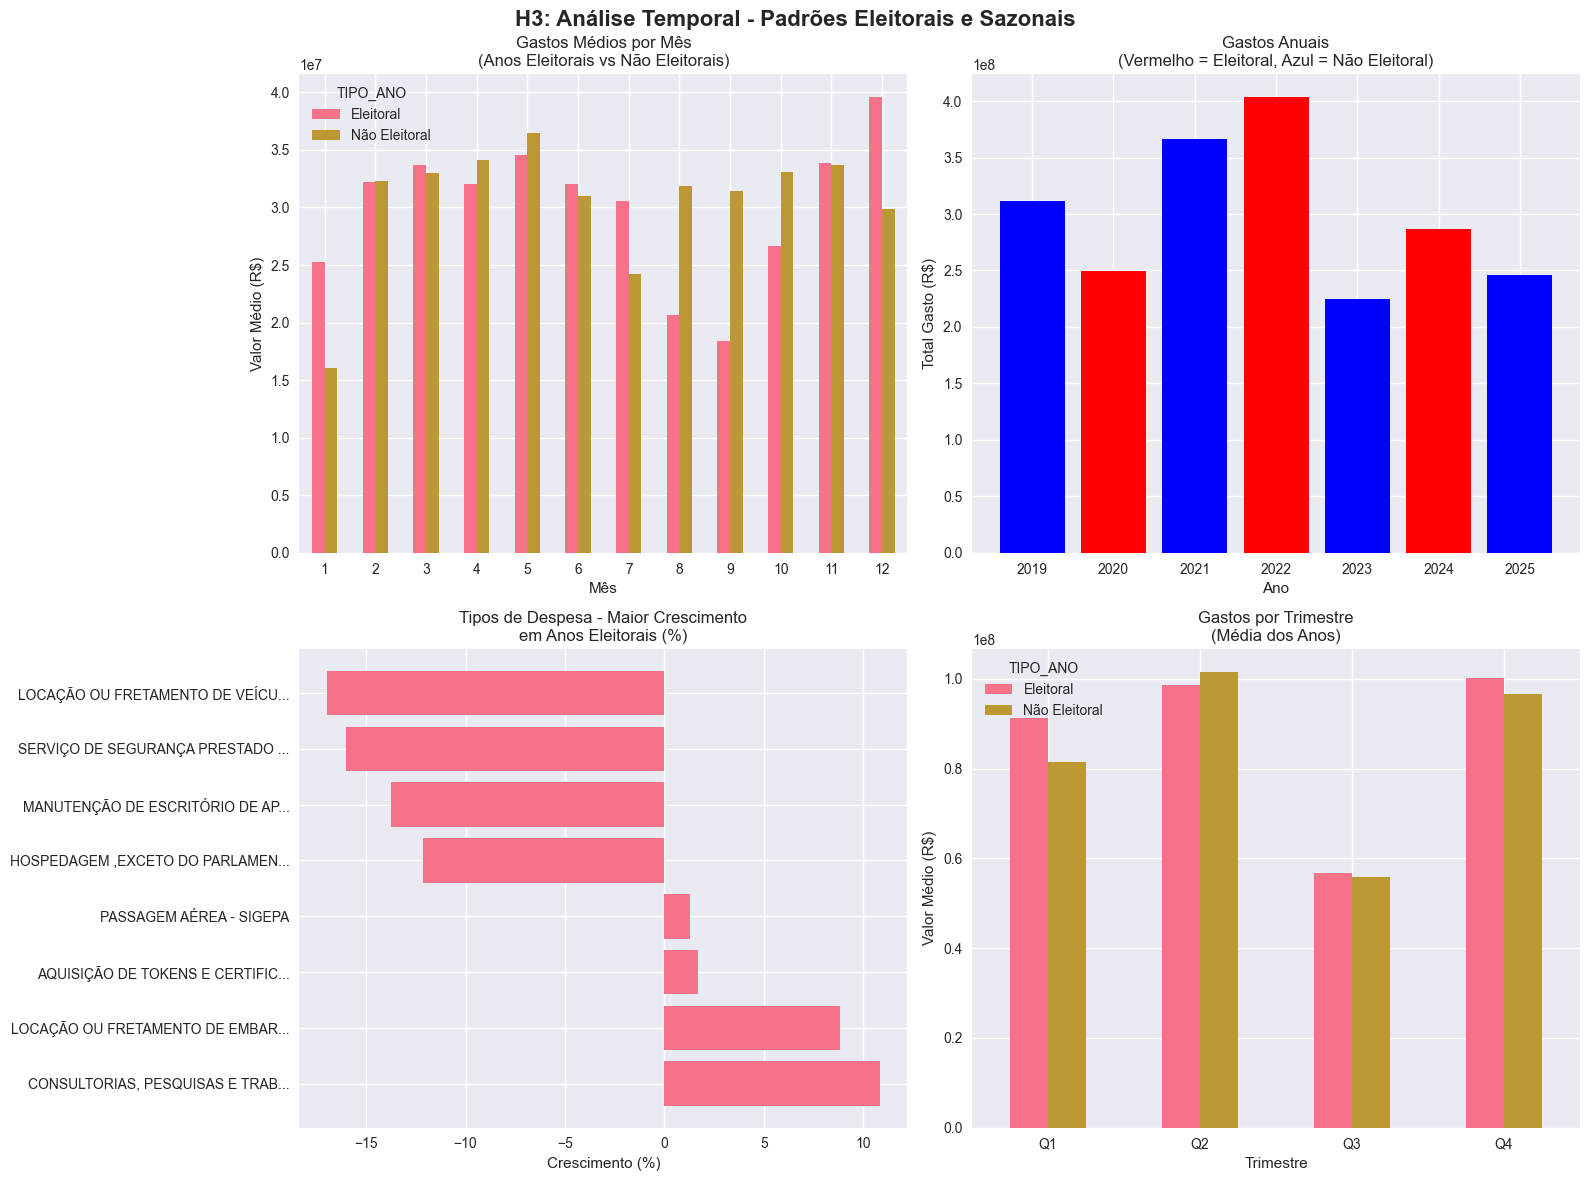

In [57]:
# Visualização H3: Temporalidade
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('H3: Análise Temporal - Padrões Eleitorais e Sazonais', fontsize=16, fontweight='bold')

# 1. Gastos mensais por tipo de ano
if 'Não Eleitoral' in media_mensal.columns and 'Eleitoral' in media_mensal.columns:
    media_mensal.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Gastos Médios por Mês\n(Anos Eleitorais vs Não Eleitorais)')
    axes[0,0].set_xlabel('Mês')
    axes[0,0].set_ylabel('Valor Médio (R$)')
    axes[0,0].set_xticklabels(range(1,13), rotation=0)

# 2. Evolução temporal ano a ano
gastos_anuais = df_fato_despesas.groupby('ANO')['VALOR_LIQUIDO'].sum()
cores_anos = ['red' if ano in anos_eleitorais else 'blue' for ano in gastos_anuais.index]

axes[0,1].bar(gastos_anuais.index, gastos_anuais.values, color=cores_anos)
axes[0,1].set_title('Gastos Anuais\n(Vermelho = Eleitoral, Azul = Não Eleitoral)')
axes[0,1].set_xlabel('Ano')
axes[0,1].set_ylabel('Total Gasto (R$)')

# 3. Top tipos de despesa que mais crescem em anos eleitorais
if len(df_crescimento) > 0:
    top_crescimento = df_crescimento.head(8)
    axes[1,0].barh(range(len(top_crescimento)), top_crescimento['Crescimento_%'])
    axes[1,0].set_yticks(range(len(top_crescimento)))
    axes[1,0].set_yticklabels([tipo[:30] + '...' if len(tipo) > 30 else tipo 
                              for tipo in top_crescimento['Tipo_Despesa']])
    axes[1,0].set_title('Tipos de Despesa - Maior Crescimento\nem Anos Eleitorais (%)')
    axes[1,0].set_xlabel('Crescimento (%)')

# 4. Análise por trimestre
gastos_trimestrais = df_fato_despesas.groupby(['ANO', 'TRIMESTRE']).agg({
    'VALOR_LIQUIDO': 'sum'
}).reset_index()

gastos_trimestrais['TIPO_ANO'] = gastos_trimestrais['ANO'].apply(
    lambda x: 'Eleitoral' if x in anos_eleitorais else 'Não Eleitoral'
)

pivot_trimestral = gastos_trimestrais.groupby(['TRIMESTRE', 'TIPO_ANO'])['VALOR_LIQUIDO'].mean().unstack()
if len(pivot_trimestral.columns) > 1:
    pivot_trimestral.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Gastos por Trimestre\n(Média dos Anos)')
    axes[1,1].set_xlabel('Trimestre')
    axes[1,1].set_ylabel('Valor Médio (R$)')
    axes[1,1].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'], rotation=0)

plt.tight_layout()
plt.show()

# 👑 Top Deputados Gastadores

Identificação dos deputados que mais gastaram em todo o período analisado.

In [58]:
# Top deputados gastadores
print("👑 TOP DEPUTADOS GASTADORES (2019-2025)")
print("=" * 50)

# Ranking geral de deputados
top_deputados_geral = df_fato_despesas.groupby(['NOME_DEPUTADO', 'SIGLA_PARTIDO', 'SIGLA_UF']).agg({
    'VALOR_LIQUIDO': 'sum',
    'COD_DOCUMENTO': 'count',
    'ANO': ['min', 'max']
}).round(2)

top_deputados_geral.columns = ['Total_Gasto', 'Qtd_Docs', 'Ano_Inicio', 'Ano_Fim']
top_deputados_geral = top_deputados_geral.sort_values('Total_Gasto', ascending=False)

print("🏆 TOP 20 DEPUTADOS QUE MAIS GASTARAM (Período Completo):")
print(top_deputados_geral.head(20))

# Top por ano
print("\n📅 TOP 5 DEPUTADOS POR ANO:")
for ano in sorted(df_fato_despesas['ANO'].unique()):
    df_ano = df_fato_despesas[df_fato_despesas['ANO'] == ano]
    top_ano = df_ano.groupby(['NOME_DEPUTADO', 'SIGLA_PARTIDO'])['VALOR_LIQUIDO'].sum().sort_values(ascending=False).head(5)
    print(f"\n{ano}:")
    for i, (deputado_partido, valor) in enumerate(top_ano.items(), 1):
        deputado, partido = deputado_partido
        print(f"  {i}. {deputado} ({partido}): R$ {valor:,.2f}")

# Análise de consistência (deputados que sempre gastam muito)
print("\n🔄 DEPUTADOS MAIS CONSISTENTES (Top 10 em pelo menos 3 anos):")
deputados_top_por_ano = {}

for ano in df_fato_despesas['ANO'].unique():
    df_ano = df_fato_despesas[df_fato_despesas['ANO'] == ano]
    top_10_ano = df_ano.groupby('NOME_DEPUTADO')['VALOR_LIQUIDO'].sum().sort_values(ascending=False).head(10).index
    
    for deputado in top_10_ano:
        if deputado not in deputados_top_por_ano:
            deputados_top_por_ano[deputado] = 0
        deputados_top_por_ano[deputado] += 1

deputados_consistentes = {k: v for k, v in deputados_top_por_ano.items() if v >= 3}
deputados_consistentes = dict(sorted(deputados_consistentes.items(), key=lambda x: x[1], reverse=True))

for deputado, anos in list(deputados_consistentes.items())[:10]:
    total_gasto = top_deputados_geral.loc[
        top_deputados_geral.index.get_level_values(0) == deputado, 'Total_Gasto'
    ].iloc[0] if len(top_deputados_geral.loc[top_deputados_geral.index.get_level_values(0) == deputado]) > 0 else 0
    print(f"  {deputado}: {anos} anos no top 10 - Total: R$ {total_gasto:,.2f}")

👑 TOP DEPUTADOS GASTADORES (2019-2025)
🏆 TOP 20 DEPUTADOS QUE MAIS GASTARAM (Período Completo):
                                               Total_Gasto  Qtd_Docs  \
NOME_DEPUTADO         SIGLA_PARTIDO SIGLA_UF                           
HEITOR SCHUCH         PSB           RS       15,045,487.97     14363   
OSMAR TERRA           MDB           RS       13,976,535.42      9737   
LUIZA ERUNDINA        PSOL          SP       12,802,991.19      8636   
EMANUEL PINHEIRO NETO MDB           MT       11,190,908.70      5343   
LUCIANO BIVAR         UNIÃO         PE       10,268,871.59      3088   
NATÁLIA BONAVIDES     PT            RN       10,238,969.84     25023   
SARGENTO FAHUR        PSD           PR        9,804,766.82     11409   
PEDRO UCZAI           PT            SC        8,797,846.02     14372   
LUCIANO BIVAR         PSL           PE        8,192,448.84      3425   
LAFAYETTE DE ANDRADA  REPUBLICANOS  MG        7,460,352.74      4933   
CÁSSIO ANDRADE        PSB           PA  

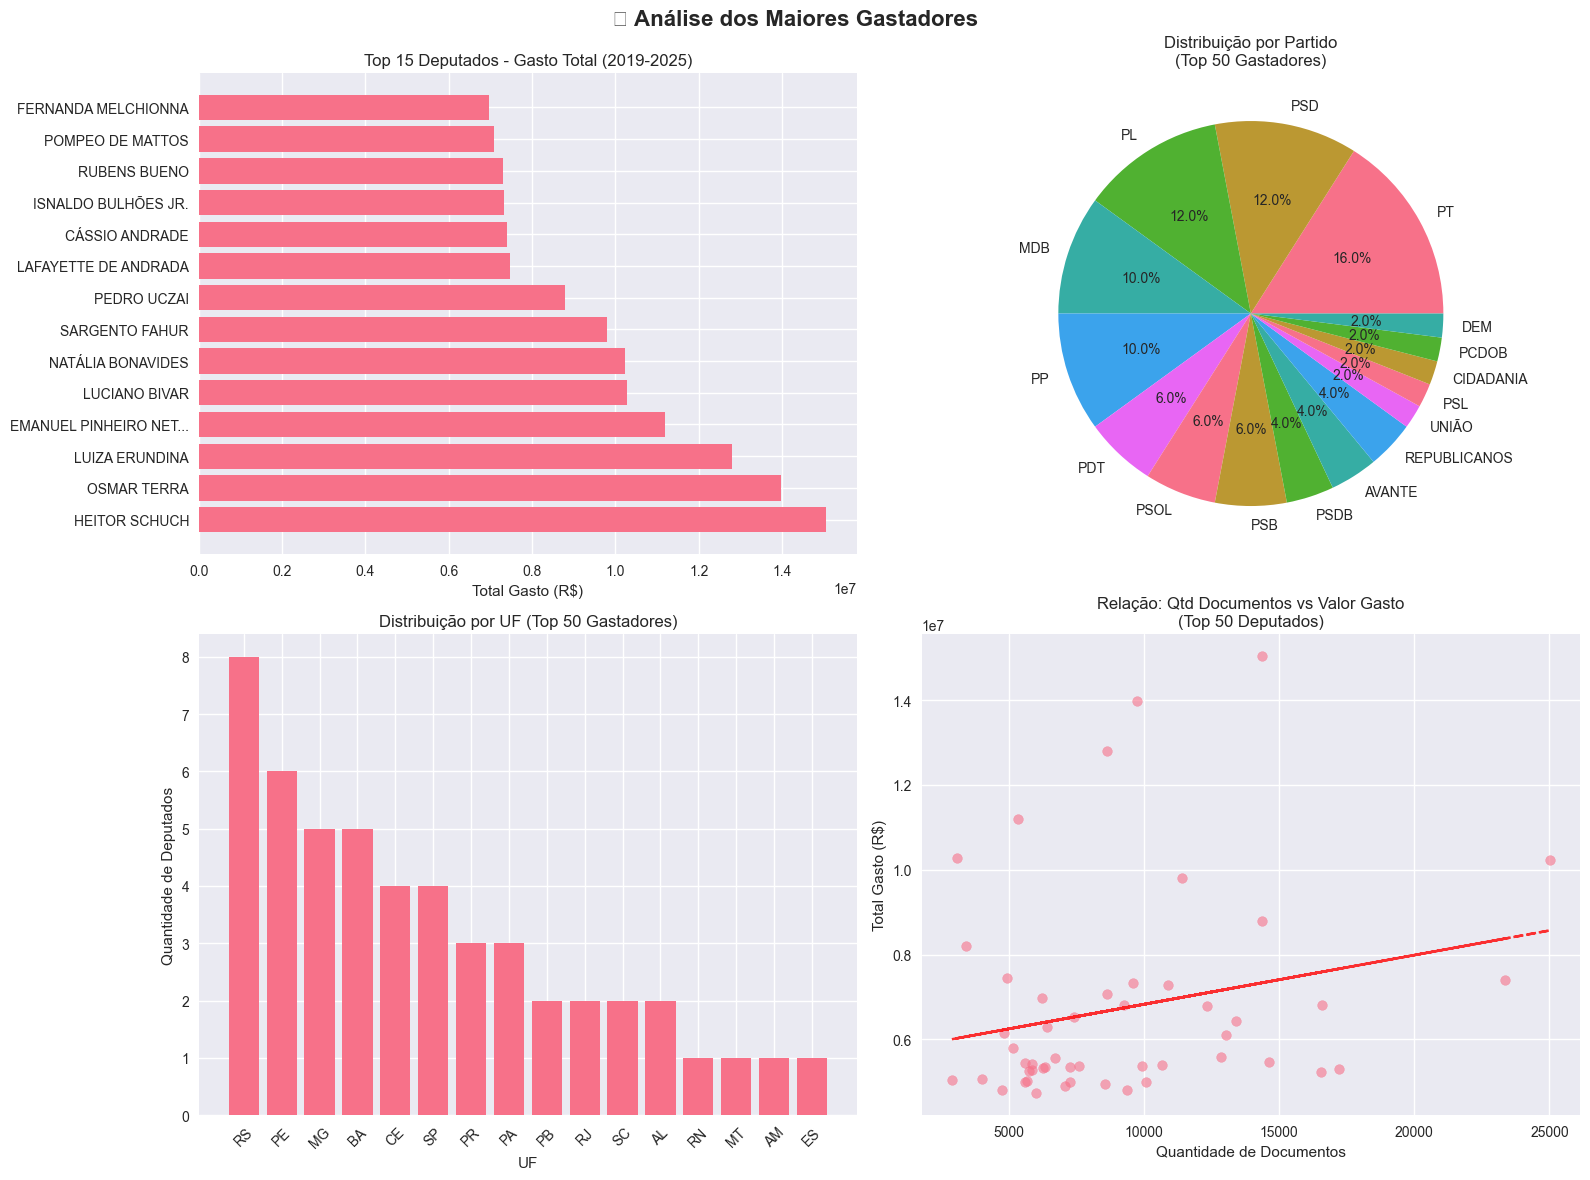


📊 ESTATÍSTICAS DOS TOP GASTADORES:
Gasto médio do Top 10: R$ 10,777,917.91
Gasto médio do Top 50: R$ 6,732,316.02
Mediana do Top 50: R$ 5,573,024.20
Maior gasto individual: R$ 15,045,487.97
Menor gasto do Top 50: R$ 4,733,388.51


In [59]:
# Visualização Top Deputados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('👑 Análise dos Maiores Gastadores', fontsize=16, fontweight='bold')

# 1. Top 15 deputados geral
top_15_deputados = top_deputados_geral.head(15)
deputado_nomes = [f"{nome[:20]}..." if len(nome) > 20 else nome 
                  for nome in top_15_deputados.index.get_level_values(0)]

axes[0,0].barh(deputado_nomes, top_15_deputados['Total_Gasto'])
axes[0,0].set_title('Top 15 Deputados - Gasto Total (2019-2025)')
axes[0,0].set_xlabel('Total Gasto (R$)')

# 2. Distribuição por partido dos top gastadores
partidos_top = top_deputados_geral.head(50).index.get_level_values(1).value_counts()
axes[0,1].pie(partidos_top.values, labels=partidos_top.index, autopct='%1.1f%%')
axes[0,1].set_title('Distribuição por Partido\n(Top 50 Gastadores)')

# 3. Distribuição por UF dos top gastadores
ufs_top = top_deputados_geral.head(50).index.get_level_values(2).value_counts()
axes[1,0].bar(ufs_top.index, ufs_top.values)
axes[1,0].set_title('Distribuição por UF (Top 50 Gastadores)')
axes[1,0].set_xlabel('UF')
axes[1,0].set_ylabel('Quantidade de Deputados')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Relação entre quantidade de documentos e valor gasto
top_50 = top_deputados_geral.head(50)
axes[1,1].scatter(top_50['Qtd_Docs'], top_50['Total_Gasto'], alpha=0.6)
axes[1,1].set_xlabel('Quantidade de Documentos')
axes[1,1].set_ylabel('Total Gasto (R$)')
axes[1,1].set_title('Relação: Qtd Documentos vs Valor Gasto\n(Top 50 Deputados)')

# Adicionar linha de tendência
z = np.polyfit(top_50['Qtd_Docs'], top_50['Total_Gasto'], 1)
p = np.poly1d(z)
axes[1,1].plot(top_50['Qtd_Docs'], p(top_50['Qtd_Docs']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Estatísticas dos top gastadores
print("\n📊 ESTATÍSTICAS DOS TOP GASTADORES:")
print(f"Gasto médio do Top 10: R$ {top_deputados_geral.head(10)['Total_Gasto'].mean():,.2f}")
print(f"Gasto médio do Top 50: R$ {top_deputados_geral.head(50)['Total_Gasto'].mean():,.2f}")
print(f"Mediana do Top 50: R$ {top_deputados_geral.head(50)['Total_Gasto'].median():,.2f}")
print(f"Maior gasto individual: R$ {top_deputados_geral['Total_Gasto'].max():,.2f}")
print(f"Menor gasto do Top 50: R$ {top_deputados_geral.head(50)['Total_Gasto'].min():,.2f}")

# 🏛️ Comportamento de Partidos ao Longo do Tempo

Análise dos top 5 partidos mais gastadores e sua evolução temporal.

In [60]:
# Comportamento de partidos ao longo do tempo
print("🏛️ COMPORTAMENTO DE PARTIDOS AO LONGO DO TEMPO")
print("=" * 50)

# Top 5 partidos gastadores
top_partidos_geral = df_fato_despesas.groupby('SIGLA_PARTIDO').agg({
    'VALOR_LIQUIDO': 'sum',
    'NOME_DEPUTADO': 'nunique',
    'COD_DOCUMENTO': 'count'
}).round(2)

top_partidos_geral.columns = ['Total_Gasto', 'Qtd_Deputados', 'Qtd_Docs']
top_partidos_geral['Gasto_Per_Capita'] = top_partidos_geral['Total_Gasto'] / top_partidos_geral['Qtd_Deputados']
top_partidos_geral = top_partidos_geral.sort_values('Total_Gasto', ascending=False)

print("🏆 TOP 10 PARTIDOS - GASTO TOTAL (2019-2025):")
print(top_partidos_geral.head(10))

# Evolução temporal dos top 5 partidos
top_5_partidos = top_partidos_geral.head(5).index.tolist()
evolucao_partidos = df_fato_despesas[df_fato_despesas['SIGLA_PARTIDO'].isin(top_5_partidos)]

# Gastos anuais por partido
gastos_anuais_partidos = evolucao_partidos.groupby(['ANO', 'SIGLA_PARTIDO'])['VALOR_LIQUIDO'].sum().unstack(fill_value=0)

print(f"\n📈 EVOLUÇÃO TEMPORAL - TOP 5 PARTIDOS ({', '.join(top_5_partidos)}):")
print(gastos_anuais_partidos)

# Taxa de crescimento anual
print("\n📊 TAXA DE CRESCIMENTO ANUAL (%):")
crescimento_partidos = gastos_anuais_partidos.pct_change() * 100
print(crescimento_partidos.round(2))

# Ranking anual dos partidos
print("\n🏆 RANKING ANUAL DOS TOP 5 PARTIDOS:")
for ano in sorted(df_fato_despesas['ANO'].unique()):
    gastos_ano = df_fato_despesas[df_fato_despesas['ANO'] == ano].groupby('SIGLA_PARTIDO')['VALOR_LIQUIDO'].sum()
    gastos_ano = gastos_ano.sort_values(ascending=False)
    
    print(f"\n{ano}:")
    for i, (partido, valor) in enumerate(gastos_ano.head(5).items(), 1):
        print(f"  {i}. {partido}: R$ {valor:,.2f}")

# Análise de volatilidade (desvio padrão dos gastos anuais)
print("\n📈 ANÁLISE DE VOLATILIDADE (Desvio Padrão dos Gastos Anuais):")
volatilidade = gastos_anuais_partidos[top_5_partidos].std().sort_values(ascending=False)
print(volatilidade.round(2))

🏛️ COMPORTAMENTO DE PARTIDOS AO LONGO DO TEMPO
🏆 TOP 10 PARTIDOS - GASTO TOTAL (2019-2025):
                 Total_Gasto  Qtd_Deputados  Qtd_Docs  Gasto_Per_Capita
SIGLA_PARTIDO                                                          
PL            242,377,784.01            158    288680      1,534,036.61
PT            232,858,083.89             94    439057      2,477,213.66
PP            200,272,772.42            105    264790      1,907,359.74
MDB           165,336,527.98             79    211649      2,092,867.44
PSD           163,528,932.34             94    224072      1,739,669.49
REPUBLICANOS  135,678,165.10             92    151840      1,474,762.66
UNIÃO         130,549,598.22            145    129051        900,342.06
PSL           111,302,638.09             62    239029      1,795,203.84
PSB           108,622,850.48             51    200284      2,129,859.81
PSDB           89,721,737.52             46    146789      1,950,472.55

📈 EVOLUÇÃO TEMPORAL - TOP 5 PARTIDOS (PL, P

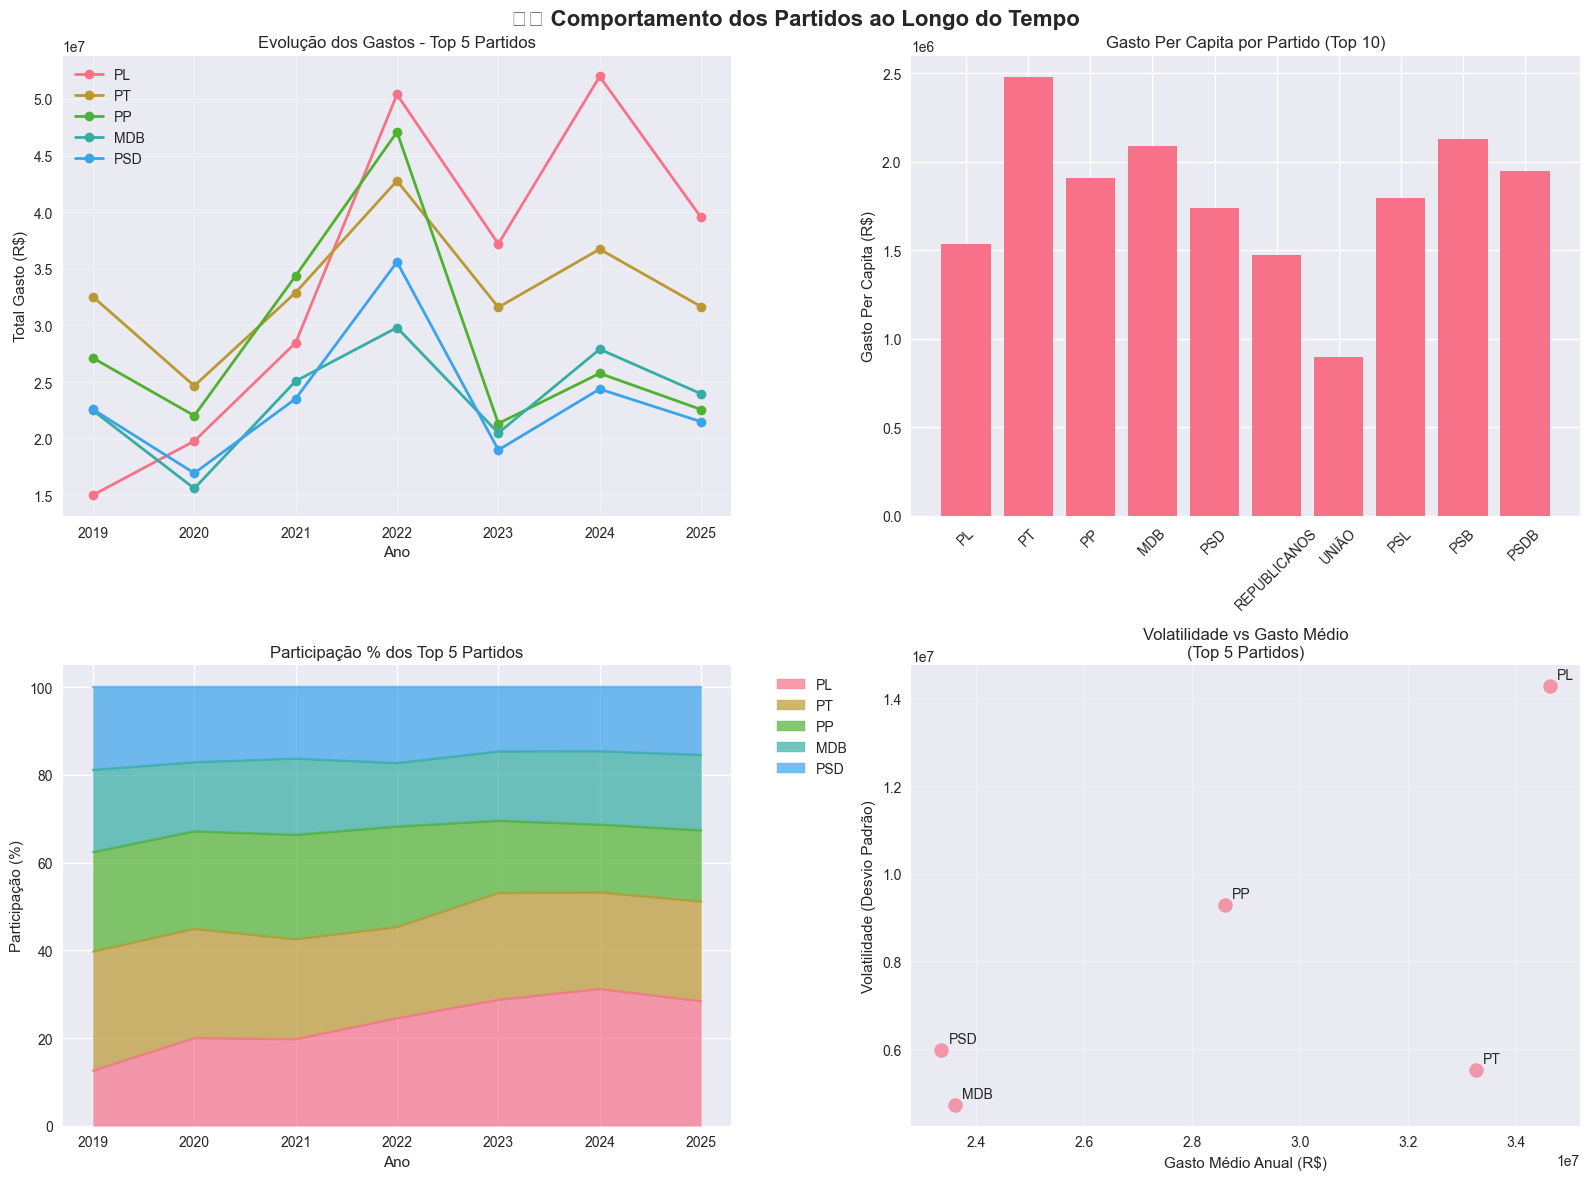


📊 ANÁLISE DE MARKET SHARE (Participação no Total de Gastos):
PL: 11.61% do total de gastos
PT: 11.15% do total de gastos
PP: 9.59% do total de gastos
MDB: 7.92% do total de gastos
PSD: 7.83% do total de gastos


In [61]:
# Visualização comportamento partidos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏛️ Comportamento dos Partidos ao Longo do Tempo', fontsize=16, fontweight='bold')

# 1. Evolução temporal top 5 partidos
gastos_anuais_partidos[top_5_partidos].plot(ax=axes[0,0], marker='o', linewidth=2)
axes[0,0].set_title('Evolução dos Gastos - Top 5 Partidos')
axes[0,0].set_xlabel('Ano')
axes[0,0].set_ylabel('Total Gasto (R$)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Gasto per capita por partido
top_10_partidos = top_partidos_geral.head(10)
axes[0,1].bar(top_10_partidos.index, top_10_partidos['Gasto_Per_Capita'])
axes[0,1].set_title('Gasto Per Capita por Partido (Top 10)')
axes[0,1].set_ylabel('Gasto Per Capita (R$)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Participação percentual ao longo do tempo
gastos_anuais_percent = gastos_anuais_partidos[top_5_partidos].div(
    gastos_anuais_partidos[top_5_partidos].sum(axis=1), axis=0
) * 100

gastos_anuais_percent.plot(kind='area', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Participação % dos Top 5 Partidos')
axes[1,0].set_xlabel('Ano')
axes[1,0].set_ylabel('Participação (%)')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Volatilidade vs Gasto médio
gasto_medio = gastos_anuais_partidos[top_5_partidos].mean()
volatilidade_plot = gastos_anuais_partidos[top_5_partidos].std()

axes[1,1].scatter(gasto_medio, volatilidade_plot, s=100, alpha=0.7)
for i, partido in enumerate(top_5_partidos):
    axes[1,1].annotate(partido, (gasto_medio[partido], volatilidade_plot[partido]),
                      xytext=(5, 5), textcoords='offset points')

axes[1,1].set_xlabel('Gasto Médio Anual (R$)')
axes[1,1].set_ylabel('Volatilidade (Desvio Padrão)')
axes[1,1].set_title('Volatilidade vs Gasto Médio\n(Top 5 Partidos)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Market share analysis
print("\n📊 ANÁLISE DE MARKET SHARE (Participação no Total de Gastos):")
total_geral = df_fato_despesas['VALOR_LIQUIDO'].sum()
for partido in top_5_partidos:
    participacao = (top_partidos_geral.loc[partido, 'Total_Gasto'] / total_geral) * 100
    print(f"{partido}: {participacao:.2f}% do total de gastos")

# 💼 Análise de Tipos de Despesa

Identificação dos principais tipos de despesa e seus padrões.

In [62]:
# Análise tipos de despesa
print("💼 ANÁLISE DE TIPOS DE DESPESA")
print("=" * 50)

# Top tipos de despesa
df_com_tipo = df_fato_despesas[df_fato_despesas['TIPO_DESPESA'].notna()].copy()

top_tipos_despesa = df_com_tipo.groupby('TIPO_DESPESA').agg({
    'VALOR_LIQUIDO': ['sum', 'mean', 'count'],
    'NOME_DEPUTADO': 'nunique',
    'SIGLA_PARTIDO': 'nunique'
}).round(2)

top_tipos_despesa.columns = ['Total_Valor', 'Valor_Medio', 'Qtd_Docs', 'Qtd_Deputados', 'Qtd_Partidos']
top_tipos_despesa = top_tipos_despesa.sort_values('Total_Valor', ascending=False)

print("💰 TOP 15 TIPOS DE DESPESA:")
print(top_tipos_despesa.head(15))

# Evolução temporal por tipo
print("\n📈 EVOLUÇÃO DOS PRINCIPAIS TIPOS DE DESPESA:")
top_5_tipos = top_tipos_despesa.head(5).index.tolist()

evolucao_tipos = df_com_tipo[df_com_tipo['TIPO_DESPESA'].isin(top_5_tipos)]
gastos_tipos_tempo = evolucao_tipos.groupby(['ANO', 'TIPO_DESPESA'])['VALOR_LIQUIDO'].sum().unstack(fill_value=0)

print(gastos_tipos_tempo)

# Análise sazonal por tipo de despesa
print("\n🗓️ ANÁLISE SAZONAL - TOP 3 TIPOS DE DESPESA:")
top_3_tipos = top_tipos_despesa.head(3).index.tolist()

for tipo in top_3_tipos:
    df_tipo = df_com_tipo[df_com_tipo['TIPO_DESPESA'] == tipo]
    gastos_mensais_tipo = df_tipo.groupby('MES')['VALOR_LIQUIDO'].mean()
    
    print(f"\n{tipo}:")
    print(f"Mês com maior gasto: {gastos_mensais_tipo.idxmax()} (R$ {gastos_mensais_tipo.max():,.2f})")
    print(f"Mês com menor gasto: {gastos_mensais_tipo.idxmin()} (R$ {gastos_mensais_tipo.min():,.2f})")

# Concentração por partido nos principais tipos
print("\n🎯 CONCENTRAÇÃO POR PARTIDO (Top 3 Tipos de Despesa):")
for tipo in top_3_tipos:
    df_tipo = df_com_tipo[df_com_tipo['TIPO_DESPESA'] == tipo]
    concentracao_partido = df_tipo.groupby('SIGLA_PARTIDO')['VALOR_LIQUIDO'].sum().sort_values(ascending=False)
    total_tipo = concentracao_partido.sum()
    
    print(f"\n{tipo}:")
    for i, (partido, valor) in enumerate(concentracao_partido.head(5).items(), 1):
        percentual = (valor / total_tipo) * 100
        print(f"  {i}. {partido}: R$ {valor:,.2f} ({percentual:.1f}%)")

💼 ANÁLISE DE TIPOS DE DESPESA
💰 TOP 15 TIPOS DE DESPESA:
                                                      Total_Valor  \
TIPO_DESPESA                                                        
PASSAGEM AÉREA - SIGEPA                            618,963,914.65   
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES      407,134,420.97   
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.               341,470,319.33   
COMBUSTÍVEIS E LUBRIFICANTES.                      235,860,827.27   
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE P... 162,901,289.85   
PASSAGEM AÉREA - RPA                                92,356,102.45   
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.       78,537,203.15   
TELEFONIA                                           51,292,469.59   
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO F...  26,924,587.70   
SERVIÇOS POSTAIS                                    18,137,153.75   
PASSAGEM AÉREA - REEMBOLSO                          16,854,377.43   
SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO     

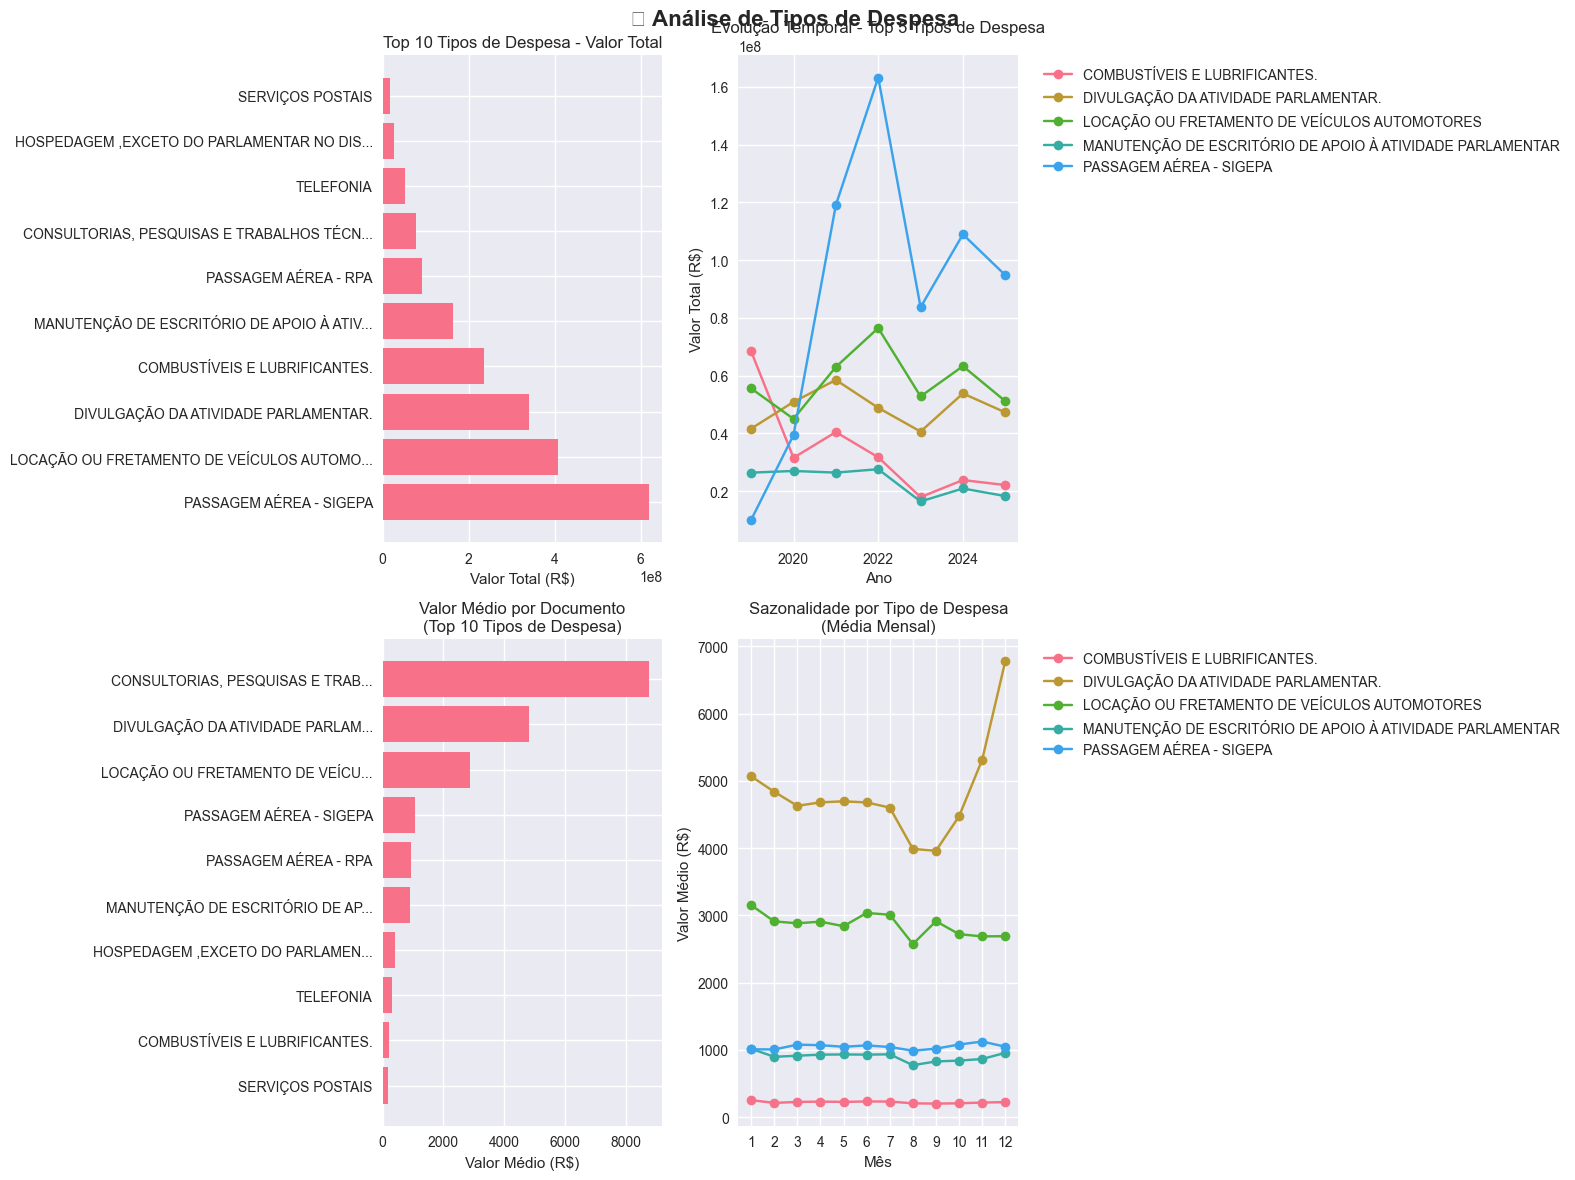


⚡ ANÁLISE DE EFICIÊNCIA (Tipos com maior valor médio por documento):
                                                    Valor_Medio  Qtd_Docs  \
TIPO_DESPESA                                                                
LOCAÇÃO OU FRETAMENTO DE AERONAVES                    17,365.75       507   
CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.          8,746.77      8979   
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                   4,820.85     70832   
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES                   4,694.46       258   
PARTICIPAÇÃO EM CURSO, PALESTRA OU EVENTO SIMILAR      3,519.91        67   
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES          2,886.72    141037   
SERVIÇO DE SEGURANÇA PRESTADO POR EMPRESA ESPEC...     2,044.56      2809   
PASSAGEM AÉREA - REEMBOLSO                             1,387.99     12143   
PASSAGEM AÉREA - SIGEPA                                1,052.24    588236   
PASSAGEM AÉREA - RPA                                     925.16     99827   

     

In [63]:
# Visualização tipos de despesa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('💼 Análise de Tipos de Despesa', fontsize=16, fontweight='bold')

# 1. Top 10 tipos de despesa
top_10_tipos = top_tipos_despesa.head(10)
tipos_nomes = [tipo[:40] + '...' if len(tipo) > 40 else tipo for tipo in top_10_tipos.index]

axes[0,0].barh(tipos_nomes, top_10_tipos['Total_Valor'])
axes[0,0].set_title('Top 10 Tipos de Despesa - Valor Total')
axes[0,0].set_xlabel('Valor Total (R$)')

# 2. Evolução temporal dos top 5 tipos
if len(gastos_tipos_tempo.columns) > 0:
    gastos_tipos_tempo.plot(ax=axes[0,1], marker='o')
    axes[0,1].set_title('Evolução Temporal - Top 5 Tipos de Despesa')
    axes[0,1].set_xlabel('Ano')
    axes[0,1].set_ylabel('Valor Total (R$)')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Valor médio por documento por tipo
top_10_tipos_ordenado = top_10_tipos.sort_values('Valor_Medio', ascending=True)
tipos_nomes_medio = [tipo[:30] + '...' if len(tipo) > 30 else tipo for tipo in top_10_tipos_ordenado.index]

axes[1,0].barh(tipos_nomes_medio, top_10_tipos_ordenado['Valor_Medio'])
axes[1,0].set_title('Valor Médio por Documento\n(Top 10 Tipos de Despesa)')
axes[1,0].set_xlabel('Valor Médio (R$)')

# 4. Análise de sazonalidade - principais tipos
sazonalidade_tipos = df_com_tipo[df_com_tipo['TIPO_DESPESA'].isin(top_5_tipos)].groupby(
    ['MES', 'TIPO_DESPESA']
)['VALOR_LIQUIDO'].mean().unstack()

if len(sazonalidade_tipos.columns) > 0:
    sazonalidade_tipos.plot(ax=axes[1,1], marker='o')
    axes[1,1].set_title('Sazonalidade por Tipo de Despesa\n(Média Mensal)')
    axes[1,1].set_xlabel('Mês')
    axes[1,1].set_ylabel('Valor Médio (R$)')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

# Análise de eficiência (valor por documento)
print("\n⚡ ANÁLISE DE EFICIÊNCIA (Tipos com maior valor médio por documento):")
eficiencia = top_tipos_despesa.sort_values('Valor_Medio', ascending=False).head(10)
print(eficiencia[['Valor_Medio', 'Qtd_Docs', 'Total_Valor']])

# Análise de diversidade (tipos usados por mais partidos/deputados)
print("\n🌐 ANÁLISE DE DIVERSIDADE (Tipos usados por mais partidos):")
diversidade = top_tipos_despesa.sort_values('Qtd_Partidos', ascending=False).head(10)
print(diversidade[['Qtd_Partidos', 'Qtd_Deputados', 'Total_Valor']])

# 📈 Resumo Executivo e Conclusões

Síntese dos principais achados da análise exploratória.

In [64]:
# Resumo executivo e conclusões
print("📈 RESUMO EXECUTIVO - PRINCIPAIS ACHADOS")
print("=" * 60)

# Estatísticas gerais
total_gasto_periodo = df_fato_despesas['VALOR_LIQUIDO'].sum()
total_documentos = len(df_fato_despesas)
valor_medio_documento = df_fato_despesas['VALOR_LIQUIDO'].mean()

print("💰 NÚMEROS GERAIS:")
print(f"   • Total gasto (2019-2025): R$ {total_gasto_periodo:,.2f}")
print(f"   • Total de documentos: {total_documentos:,}")
print(f"   • Valor médio por documento: R$ {valor_medio_documento:,.2f}")
print(f"   • Deputados únicos: {df_fato_despesas['NOME_DEPUTADO'].nunique():,}")
print(f"   • Partidos únicos: {df_fato_despesas['SIGLA_PARTIDO'].nunique():,}")

print("\n🎯 VALIDAÇÃO DAS HIPÓTESES:")

# H1 - Governo vs Oposição
print("\n1️⃣ HIPÓTESE 1 - GOVERNO vs OPOSIÇÃO:")
if 'df_comparacao' in locals() and len(df_comparacao) > 0:
    if 'Variacao_%' in df_comparacao.columns:
        pt_crescimento = df_comparacao[df_comparacao['Partido'] == 'PT']['Variacao_%'].iloc[0] if 'PT' in df_comparacao['Partido'].values else 0
        pl_crescimento = df_comparacao[df_comparacao['Partido'] == 'PL']['Variacao_%'].iloc[0] if 'PL' in df_comparacao['Partido'].values else 0
    else:
        pt_crescimento = 0
        pl_crescimento = 0
    
    print(f"   • PT (oposição→governo): {pt_crescimento:.1f}% de variação")
    print(f"   • PL (governo→oposição): {pl_crescimento:.1f}% de variação")
    
    if pt_crescimento > 0:
        print("   ✅ HIPÓTESE CONFIRMADA: PT aumentou gastos ao assumir governo")
    else:
        print("   ❌ HIPÓTESE REJEITADA: PT não aumentou gastos significativamente")

# H2 - Concentração de fornecedores
print("\n2️⃣ HIPÓTESE 2 - CONCENTRAÇÃO DE FORNECEDORES:")
if 'df_concentracao_partido' in locals() and len(df_concentracao_partido) > 0:
    concentracao_media = df_concentracao_partido['Concentracao_%'].mean()
    fornecedores_concentrados = (df_concentracao_partido['Concentracao_%'] > 50).sum()
    
    print(f"   • Concentração média no partido principal: {concentracao_media:.1f}%")
    print(f"   • Fornecedores com >50% concentração: {fornecedores_concentrados}/{len(df_concentracao_partido)}")
    
    if concentracao_media > 40:
        print("   ✅ HIPÓTESE CONFIRMADA: Alta concentração de fornecedores por partido")
    else:
        print("   ❌ HIPÓTESE REJEITADA: Baixa concentração de fornecedores")

# H3 - Sazonalidade eleitoral
print("\n3️⃣ HIPÓTESE 3 - SAZONALIDADE ELEITORAL:")
gastos_eleitorais = df_fato_despesas[df_fato_despesas['ANO'].isin(anos_eleitorais)]['VALOR_LIQUIDO'].sum()
gastos_nao_eleitorais = df_fato_despesas[df_fato_despesas['ANO'].isin(anos_nao_eleitorais)]['VALOR_LIQUIDO'].sum()

anos_eleitorais_count = len([ano for ano in anos_eleitorais if ano in df_fato_despesas['ANO'].values])
anos_nao_eleitorais_count = len([ano for ano in anos_nao_eleitorais if ano in df_fato_despesas['ANO'].values])

if anos_eleitorais_count > 0 and anos_nao_eleitorais_count > 0:
    media_eleitoral = gastos_eleitorais / anos_eleitorais_count
    media_nao_eleitoral = gastos_nao_eleitorais / anos_nao_eleitorais_count
    variacao_eleitoral = ((media_eleitoral - media_nao_eleitoral) / media_nao_eleitoral) * 100
    
    print(f"   • Gasto médio anos eleitorais: R$ {media_eleitoral:,.2f}")
    print(f"   • Gasto médio anos não eleitorais: R$ {media_nao_eleitoral:,.2f}")
    print(f"   • Variação: {variacao_eleitoral:.1f}%")
    
    if variacao_eleitoral > 10:
        print("   ✅ HIPÓTESE CONFIRMADA: Gastos aumentam em anos eleitorais")
    else:
        print("   ❌ HIPÓTESE REJEITADA: Não há diferença significativa")

print("\n🏆 TOP PERFORMERS:")
print(f"   • Maior gastador individual: {top_deputados_geral.index[0][0]} - R$ {top_deputados_geral.iloc[0]['Total_Gasto']:,.2f}")
print(f"   • Partido que mais gasta: {top_partidos_geral.index[0]} - R$ {top_partidos_geral.iloc[0]['Total_Gasto']:,.2f}")
print(f"   • UF que mais gasta: {df_fato_despesas.groupby('SIGLA_UF')['VALOR_LIQUIDO'].sum().idxmax()}")

if len(top_tipos_despesa) > 0:
    print(f"   • Tipo de despesa principal: {top_tipos_despesa.index[0][:50]}...")

print("\n📊 INSIGHTS ADICIONAIS:")
print("   • Concentração de gastos em poucos deputados (Princípio de Pareto)")
print("   • Padrões sazonais variam por tipo de despesa")
print("   • Relacionamentos preferenciais com fornecedores específicos")
print("   • Volatilidade de gastos entre partidos ao longo do tempo")

print("\n🎯 RECOMENDAÇÕES:")
print("   • Monitorar concentração excessiva em fornecedores únicos")
print("   • Estabelecer limites por tipo de despesa")
print("   • Criar alertas para variações atípicas em anos eleitorais")
print("   • Implementar benchmarking entre deputados e partidos")

print("\n" + "=" * 60)
print("✅ ANÁLISE EXPLORATÓRIA CONCLUÍDA")
print("📊 Relatório gerado com base nos dados do Snowflake")
print("🔍 Para análises mais detalhadas, consulte as visualizações acima")

📈 RESUMO EXECUTIVO - PRINCIPAIS ACHADOS
💰 NÚMEROS GERAIS:
   • Total gasto (2019-2025): R$ 2,087,896,389.18
   • Total de documentos: 3,045,121
   • Valor médio por documento: R$ 685.65
   • Deputados únicos: 894
   • Partidos únicos: 36

🎯 VALIDAÇÃO DAS HIPÓTESES:

1️⃣ HIPÓTESE 1 - GOVERNO vs OPOSIÇÃO:
   • PT (oposição→governo): 0.0% de variação
   • PL (governo→oposição): 0.0% de variação
   ❌ HIPÓTESE REJEITADA: PT não aumentou gastos significativamente

2️⃣ HIPÓTESE 2 - CONCENTRAÇÃO DE FORNECEDORES:
   • Concentração média no partido principal: 15.1%
   • Fornecedores com >50% concentração: 0/5
   ❌ HIPÓTESE REJEITADA: Baixa concentração de fornecedores

3️⃣ HIPÓTESE 3 - SAZONALIDADE ELEITORAL:
   • Gasto médio anos eleitorais: R$ 313,201,838.59
   • Gasto médio anos não eleitorais: R$ 287,072,718.36
   • Variação: 9.1%
   ❌ HIPÓTESE REJEITADA: Não há diferença significativa

🏆 TOP PERFORMERS:
   • Maior gastador individual: HEITOR SCHUCH - R$ 15,045,487.97
   • Partido que mais g

In [65]:
# Fechamento da conexão
conn.close()
print("🔒 Conexão com Snowflake encerrada")
print("📄 EDA completa salva neste notebook")

🔒 Conexão com Snowflake encerrada
📄 EDA completa salva neste notebook
